### Purpose of this file ###
The file B2356run2.mat holds the transient info for the tire run that we care about. 

In this file, we try to synthesize the following : 
- Tire Temp versus Time
- $\mu (x)$ and $\mu (y)$ versus temp
- The value L (relaxation length -- distance traveled to hit 67.2% of total distance)

In [1]:
import numpy as np 
from scipy.io import loadmat
import matplotlib.pyplot as plt 
import pandas as pd 

In [2]:
mat = loadmat('B2356run2.mat')
mat = {k:v for k, v in mat.items() if k not in {'__header__', '__version__', '__globals__', 'channel', 'source', 'testid', 'tireid'}}

# each column is of shape (58755, 1). Need to squeeze into 1D
mat = {k:v.squeeze() for k,v in mat.items()}
df = pd.DataFrame(mat)
# sort values in order of increasing time
df = df.sort_values(by='ET')
df.shape
df.head()

,AMBTMP,ET,FX,FY,FZ,IA,MX,MZ,N,NFX,...,RL,RST,RUN,SA,SL,SR,TSTC,TSTI,TSTO,V
0,25.55,0.16,2.10,-28.53,-662.39,-0.005,-5.48,0.98,0.03,-0.0032,...,19.54,26.97,2,-0.003,-0.0,-0.6365,26.25,26.29,27.29,0.01
1,25.55,0.17,3.05,-28.05,-665.15,0.013,-4.50,1.42,-0.04,-0.0046,...,19.53,27.00,2,-0.004,-0.0,-1.0932,26.25,26.30,27.25,0.03
2,25.57,0.18,1.83,-29.31,-661.93,0.001,-6.25,0.85,0.03,-0.0028,...,19.53,27.00,2,0.006,-0.0,-0.9547,26.23,26.35,27.25,0.04
3,25.56,0.19,1.83,-29.24,-661.79,-0.005,-6.04,0.82,0.09,-0.0028,...,19.54,27.02,2,0.002,-0.0,-0.7908,26.24,26.31,27.27,0.03
4,25.55,0.20,2.11,-30.81,-663.24,0.010,-6.20,1.06,0.03,-0.0032,...,19.53,27.04,2,0.006,-0.0,-0.9547,26.26,26.32,27.26,0.04


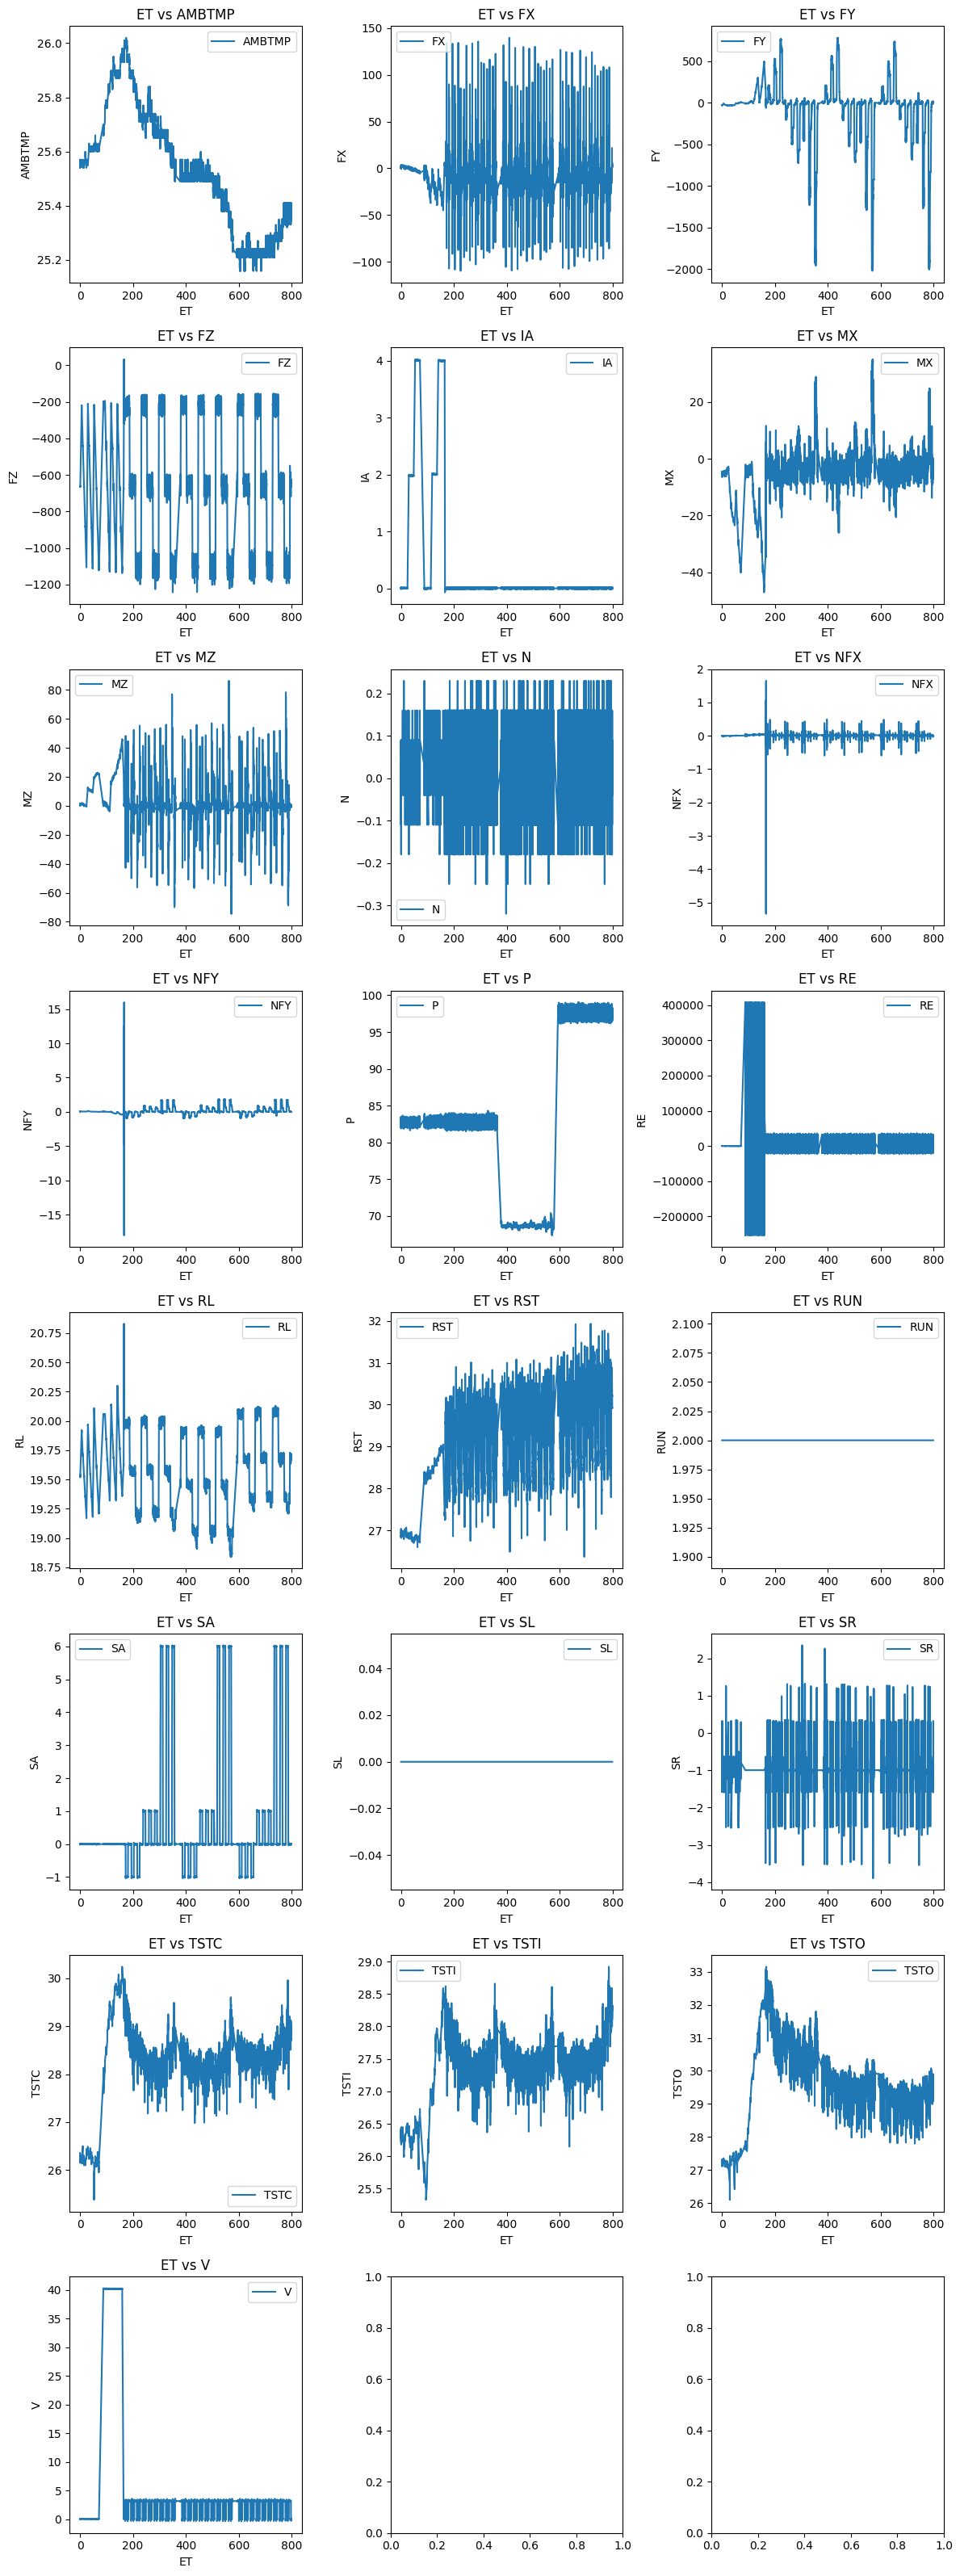

In [ ]:
import matplotlib.pyplot as plt
import itertools

columns_to_plot = [col for col in df.columns if col != 'ET']

n_plots = len(list(columns_to_plot))
n_rows = int(np.ceil((n_plots) / 3))  # Arrange 3 plots per row

fig, axes = plt.subplots(n_rows, 3, figsize=(12, n_rows * 4))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Plot every column w.r.t ET
for i, col in enumerate(columns_to_plot):
    ax = axes[i]
    ax.plot(df['ET'], df[col], label=col)
    ax.set_title(f"ET vs {col}")
    ax.set_xlabel('ET')
    ax.set_ylabel(col)
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()
